<a href="https://colab.research.google.com/github/JTStephens18/instant_ngp_test/blob/main/InstantNGP_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt update && apt install build-essential git python3-dev python3-pip libopenexr-dev libxi-dev libglfw3-dev libglew-dev libomp-dev libxinerama-dev libxcursor-dev colmap ffmpeg jq
!pip install --upgrade cmake

Find the compute capability of the GPU in your local machine in the following link: https://developer.nvidia.com/cuda-gpus

You need this to be able to open your trained models in testbed inside your local machine later on, so you can explore them or trace a camera path in order to generate a video from your scene.

In [ ]:
compute_capability = "61" #@param [50, 52, 60, 61, 70, 72, 75, 80, 86, 87]
%env TCNN_CUDA_ARCHITECTURES=$compute_capability

For compatibility between the model trained here and the local machine, a network with FP32 or FP16 is chosen.

https://docs.nvidia.com/deeplearning/tensorrt/support-matrix/index.html#hardware-precision-matrix

In [ ]:
network_type = "FullyFusedMLP" if int(compute_capability) >= 70 else "CutlassMLP"
print(f"Using {network_type}")
%env NN_CONFIG_PATH = ./configs/nerf/base.json
!jq '.network.otype = "CutlassMLP" | .rgb_network.otype = "CutlassMLP"' NN_CONFIG_PATH

Build the project and install python requirements

In [ ]:
!cmake . -B build -DNGP_BUILD_WITH_GUI=OFF

In [ ]:
import os
scene_path = "/content/drive/MyDrive/nerf_scenes/fox" #@param {type:"string"}
if not os.path.isdir(scene_path):
  raise NotADirectoryError(scene_path)

In [ ]:
train_steps = 2000  #@param {type:"integer"}
snapshot_path = os.path.join(scene_path, f"{train_steps}.ingp")
!python ./scripts/run.py {scene_path} --n_steps {train_steps} --save_snapshot {snapshot_path}

# From Scratch

In [1]:
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from PIL import Image

In [2]:
device = "cpu"

In [2]:
class NGP(torch.nn.Module):

    def __init__(self, T, Nl, L, device, aabb_scale, F=2):
        super(NGP, self).__init__()
        self.T = T
        self.Nl = Nl
        self.F = F
        self.L = L  # For encoding directions
        self.aabb_scale = aabb_scale
        self.lookup_tables = torch.nn.ParameterDict(
            {str(i): torch.nn.Parameter((torch.rand(
                (T, 2), device=device) * 2 - 1) * 1e-4) for i in range(len(Nl))})
        self.pi1, self.pi2, self.pi3 = 1, 2_654_435_761, 805_459_861
        self.density_MLP = nn.Sequential(nn.Linear(self.F * len(Nl), 64),
                                         nn.ReLU(), nn.Linear(64, 16)).to(device)
        self.color_MLP = nn.Sequential(nn.Linear(27 + 16, 64), nn.ReLU(),
                                       nn.Linear(64, 64), nn.ReLU(),
                                       nn.Linear(64, 3), nn.Sigmoid()).to(device)

    def positional_encoding(self, x):
        out = [x]
        for j in range(self.L):
            out.append(torch.sin(2 ** j * x))
            out.append(torch.cos(2 ** j * x))
        return torch.cat(out, dim=1)

    def forward(self, x, d):

        x /= self.aabb_scale
        mask = (x[:, 0].abs() < .5) & (x[:, 1].abs() < .5) & (x[:, 2].abs() < .5)
        x += 0.5  # x in [0, 1]^3

        color = torch.zeros((x.shape[0], 3), device=x.device)
        log_sigma = torch.zeros((x.shape[0]), device=x.device) - 100000
        features = torch.empty((x[mask].shape[0], self.F * len(self.Nl)), device=x.device)
        for i, N in enumerate(self.Nl):
            # Computing vertices, use nn.functional.grid_sample convention
            floor = torch.floor(x[mask] * N)
            ceil = torch.ceil(x[mask] * N)
            vertices = torch.zeros((x[mask].shape[0], 8, 3), dtype=torch.int64, device=x.device)
            vertices[:, 0] = floor
            vertices[:, 1] = torch.cat((ceil[:, 0, None], floor[:, 1, None], floor[:, 2, None]), dim=1)
            vertices[:, 2] = torch.cat((floor[:, 0, None], ceil[:, 1, None], floor[:, 2, None]), dim=1)
            vertices[:, 4] = torch.cat((floor[:, 0, None], floor[:, 1, None], ceil[:, 2, None]), dim=1)
            vertices[:, 6] = torch.cat((floor[:, 0, None], ceil[:, 1, None], ceil[:, 2, None]), dim=1)
            vertices[:, 5] = torch.cat((ceil[:, 0, None], floor[:, 1, None], ceil[:, 2, None]), dim=1)
            vertices[:, 3] = torch.cat((ceil[:, 0, None], ceil[:, 1, None], floor[:, 2, None]), dim=1)
            vertices[:, 7] = ceil

            # hashing
            a = vertices[:, :, 0] * self.pi1
            b = vertices[:, :, 1] * self.pi2
            c = vertices[:, :, 2] * self.pi3
            h_x = torch.remainder(torch.bitwise_xor(torch.bitwise_xor(a, b), c), self.T)

            # Lookup
            looked_up = self.lookup_tables[str(i)][h_x].transpose(-1, -2)
            volume = looked_up.reshape((looked_up.shape[0], 2, 2, 2, 2))
            features[:, i*2:(i+1)*2] = torch.nn.functional.grid_sample(
                volume,
                ((x[mask] * N - floor) - 0.5).unsqueeze(1).unsqueeze(1).unsqueeze(1)
                ).squeeze(-1).squeeze(-1).squeeze(-1)

        xi = self.positional_encoding(d[mask])
        h = self.density_MLP(features)
        log_sigma[mask] = h[:, 0]
        color[mask] = self.color_MLP(torch.cat((h, xi), dim=1))
        return color, torch.exp(log_sigma)

In [3]:
def compute_accumulated_transmittance(alphas):
    accumulated_transmittance = torch.cumprod(alphas, 1)
    return torch.cat((torch.ones((accumulated_transmittance.shape[0], 1), device=alphas.device),
                      accumulated_transmittance[:, :-1]), dim=-1)

In [4]:
def render_rays(nerf_model, ray_origins, ray_directions, hn=0, hf=0.5, nb_bins=192):
    device = ray_origins.device
    t = torch.linspace(hn, hf, nb_bins, device=device).expand(ray_origins.shape[0], nb_bins)
    t = t.unsqueeze(-1).unsqueeze(-1).expand(ray_origins.shape[0], nb_bins, ray_origins.shape[2], ray_origins.shape[3])
    # # Perturb sampling along each ray.
    # mid = (t[:, :-1] + t[:, 1:]) / 2.
    # lower = torch.cat((t[:, :1], mid), -1)
    # upper = torch.cat((mid, t[:, -1:]), -1)
    # u = torch.rand(t.shape, device=device)
    # t = lower + (upper - lower) * u  # [batch_size, nb_bins]
    # delta = torch.cat((t[:, 1:] - t[:, :-1], torch.tensor(
    #     [1e10], device=device).expand(ray_origins.shape[0], 1)), -1)


        # Perturb sampling along each ray.
    mid = (t[:, :-1, :, :] + t[:, 1:, :, :]) / 2.0
    lower = torch.cat((t[:, :1, :, :], mid), 1)
    upper = torch.cat((mid, t[:, -1:, :, :]), 1)
    u = torch.rand(t.shape, device=device)
    t = lower + (upper - lower) * u  # [batch_size, nb_bins, height, width]

    delta = torch.cat((t[:, 1:, :, :] - t[:, :-1, :, :], torch.tensor([1e10], device=device).expand(ray_origins.shape[0], 1, ray_origins.shape[2], ray_origins.shape[3])), 1)

    print("\n")
    print("ray origins", ray_origins.shape)
    print("ray origins unsqueeze", ray_origins.unsqueeze(1).shape)
    print("t", t.shape)
    print("t unsqueeze", t.unsqueeze(2).shape)
    print("ray direction shape", ray_directions.shape)
    print("ray direction unsqueeze", ray_directions.unsqueeze(1).shape)

    # Compute the 3D points along each ray
    x = ray_origins.unsqueeze(1) + t.unsqueeze(2) * ray_directions.unsqueeze(1)
    # Expand the ray_directions tensor to match the shape of x
    ray_directions = ray_directions.expand(nb_bins, ray_directions.shape[0], 3).transpose(0, 1)
    colors, sigma = nerf_model(x.reshape(-1, 3), ray_directions.reshape(-1, 3))
    alpha = 1 - torch.exp(-sigma.reshape(x.shape[:-1]) * delta)  # [batch_size, nb_bins]
    weights = compute_accumulated_transmittance(1 - alpha).unsqueeze(2) * alpha.unsqueeze(2)
    c = (weights * colors.reshape(x.shape)).sum(dim=1)
    weight_sum = weights.sum(-1).sum(-1)  # Regularization for white background
    return c + 1 - weight_sum.unsqueeze(-1)

In [5]:
@torch.no_grad()
def test(hn, hf, dataset, img_index, chunk_size=20, nb_bins=192, H=400, W=400):
    ray_origins = dataset[img_index * H * W: (img_index + 1) * H * W, :3]
    ray_directions = dataset[img_index * H * W: (img_index + 1) * H * W, 3:6]

    px_values = []   # list of regenerated pixel values
    for i in range(int(np.ceil(H / chunk_size))):   # iterate over chunks
        ray_origins_ = ray_origins[i * W * chunk_size: (i + 1) * W * chunk_size].to(device)
        ray_directions_ = ray_directions[i * W * chunk_size: (i + 1) * W * chunk_size].to(device)
        px_values.append(render_rays(model, ray_origins_, ray_directions_,
                                     hn=hn, hf=hf, nb_bins=nb_bins))
    img = torch.cat(px_values).data.cpu().numpy().reshape(H, W, 3)
    img = (img.clip(0, 1)*255.).astype(np.uint8)
    img = Image.fromarray(img)
    img.save(f'novel_views/img_{img_index}.png')

In [6]:
def train(nerf_model, optimizer, data_loader, device='cpu', hn=0, hf=1, nb_epochs=10,
          nb_bins=192, H=400, W=400):
    for _ in range(nb_epochs):
        for batch, _ in tqdm(data_loader):
            ray_origins = batch[:, :3].to(device)
            ray_directions = batch[:, 3:6].to(device)
            gt_px_values = batch[:, 6:].to(device)
            pred_px_values = render_rays(nerf_model, ray_origins, ray_directions,
                                         hn=hn, hf=hf, nb_bins=nb_bins)
            loss = ((gt_px_values - pred_px_values) ** 2).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [7]:
device = 'cuda'
# training_dataset = torch.from_numpy(np.load('training_data_800x800.pkl',
#                                             allow_pickle=True))

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
])

# Path to the image folder
image_folder_path = '/content/drive/MyDrive/text2scene'

# Create a dataset from the folder
training_dataset = datasets.ImageFolder(root=image_folder_path, transform=transform)

indices = list(range(len(training_dataset) // 2))

subset_dataset = Subset(training_dataset, indices)

# testing_dataset = torch.from_numpy(np.load('testing_data_800x800.pkl',
#                                             allow_pickle=True))
L = 16
F = 2
T = 2**19
N_min = 16
N_max = 2048
b = np.exp((np.log(N_max) - np.log(N_min)) / (L - 1))
Nl = [int(np.floor(N_min * b**l)) for l in range(L)]
model = NGP(T, Nl, 4, device, 3)
model_optimizer = torch.optim.Adam(
    [{"params": model.lookup_tables.parameters(), "lr": 1e-2, "betas": (0.9, 0.99), "eps": 1e-15, "weight_decay": 0.},
      {"params": model.density_MLP.parameters(), "lr": 1e-2,  "betas": (0.9, 0.99), "eps": 1e-15, "weight_decay": 10**-6},
      {"params": model.color_MLP.parameters(), "lr": 1e-2,  "betas": (0.9, 0.99), "eps": 1e-15, "weight_decay": 10**-6}])
data_loader = DataLoader(subset_dataset, batch_size=2**14, shuffle=True)

train(model, model_optimizer, data_loader, nb_epochs=1, device=device,
      hn=2, hf=6, nb_bins=192, H=378, W=504)
# for img_index in range(200):
#     test(2, 6, testing_dataset, img_index, nb_bins=192, H=800, W=800)

  0%|          | 0/1 [00:09<?, ?it/s]



ray origins torch.Size([14, 3, 378, 504])
ray origins unsqueeze torch.Size([14, 1, 3, 378, 504])
t torch.Size([14, 192, 378, 504])
t unsqueeze torch.Size([14, 192, 1, 378, 504])
ray direction shape torch.Size([14, 0, 378, 504])
ray direction unsqueeze torch.Size([14, 1, 0, 378, 504])


RuntimeError: The size of tensor a (3) must match the size of tensor b (0) at non-singleton dimension 2

In [26]:
import collections
import struct

def read_next_bytes(fid, num_bytes, format_char_sequence, endian_character="<"):
    """Read and unpack the next bytes from a binary file.
    :param fid:
    :param num_bytes: Sum of combination of {2, 4, 8}, e.g. 2, 6, 16, 30, etc.
    :param format_char_sequence: List of {c, e, f, d, h, H, i, I, l, L, q, Q}.
    :param endian_character: Any of {@, =, <, >, !}
    :return: Tuple of read and unpacked values.
    """
    data = fid.read(num_bytes)
    return struct.unpack(endian_character + format_char_sequence, data)


def read_cameras_binary(path):
  cameras = []
  camObj = {}
  with open(path, 'rb') as fid:
    num_cam = read_next_bytes(fid, 8, "Q")[0]
    print("num_cam", num_cam)
    for _ in range(num_cam):
      cam_prop = read_next_bytes(fid, num_bytes=24, format_char_sequence="iiQQ")
      cam_id = cam_prop[0]
      # print("camera id", cam_id)
      # print("model prop", cam_prop[1])
      # print("width prop", cam_prop[2])
      # print("height prop", cam_prop[3])
      num_params = 4
      params = read_next_bytes(fid, num_bytes=8 * num_params, format_char_sequence="d" * num_params)
      # print("params", params)
      cameras.append({
          "id": cam_id,
          "width": cam_prop[2],
          "height": cam_prop[3],
          "params": torch.tensor(params)
      })

      camObj[cam_id] = {
          "id": cam_id,
          "width": cam_prop[2],
          "height": cam_prop[3],
          "params": np.array(params)
      }

  return cameras, num_cam, camObj


cam_intrinsic, num_cameras, camObj = read_cameras_binary("/content/cameras.bin")

num_cam 1


In [27]:
print(cam_intrinsic)

[{'id': 1, 'width': 1008, 'height': 756, 'params': tensor([740.3248, 742.6179, 504.0000, 378.0000])}]


In [28]:
def read_images_binary(path_to_model_file):
    """
    see: src/colmap/scene/reconstruction.cc
        void Reconstruction::ReadImagesBinary(const std::string& path)
        void Reconstruction::WriteImagesBinary(const std::string& path)
    """
    images = {}
    imgArr = []
    with open(path_to_model_file, "rb") as fid:
        num_reg_images = read_next_bytes(fid, 8, "Q")[0]
        print("num_reg_images", num_reg_images)
        for _ in range(num_reg_images):
            binary_image_properties = read_next_bytes(
                fid, num_bytes=64, format_char_sequence="idddddddi"
            )
            image_id = binary_image_properties[0]
            qvec = np.array(binary_image_properties[1:5])
            tvec = np.array(binary_image_properties[5:8])
            camera_id = binary_image_properties[8]
            binary_image_name = b""
            current_char = read_next_bytes(fid, 1, "c")[0]
            while current_char != b"\x00":  # look for the ASCII 0 entry
                binary_image_name += current_char
                current_char = read_next_bytes(fid, 1, "c")[0]
            image_name = binary_image_name.decode("utf-8")
            num_points2D = read_next_bytes(
                fid, num_bytes=8, format_char_sequence="Q"
            )[0]
            x_y_id_s = read_next_bytes(
                fid,
                num_bytes=24 * num_points2D,
                format_char_sequence="ddq" * num_points2D,
            )
            xys = np.column_stack(
                [
                    tuple(map(float, x_y_id_s[0::3])),
                    tuple(map(float, x_y_id_s[1::3])),
                ]
            )
            point3D_ids = np.array(tuple(map(int, x_y_id_s[2::3])))
            images[image_id] = {
                "id": image_id,
                "qvec": qvec,
                "tvec": tvec,
                "camera_id": camera_id,
                "name": image_name,
                "xys": xys,
                "point3D_ids": point3D_ids
            }
            imgArr.append({
                "id": image_id,
                "qvec": qvec,
                "tvec": tvec,
                "camera_id": camera_id,
                "name": image_name,
                "xys": xys,
                "point3D_ids": point3D_ids
            })
    return images, imgArr

ce, cam_extrinsic = read_images_binary("/content/images.bin")

num_reg_images 29


In [5]:
def qvec2rotmat(qvec):
  return np.array([
    [1 - 2 * qvec[2]**2 - 2 * qvec[3]**2,
      2 * qvec[1] * qvec[2] - 2 * qvec[0] * qvec[3],
      2 * qvec[3] * qvec[1] + 2 * qvec[0] * qvec[2]],
    [2 * qvec[1] * qvec[2] + 2 * qvec[0] * qvec[3],
      1 - 2 * qvec[1]**2 - 2 * qvec[3]**2,
      2 * qvec[2] * qvec[3] - 2 * qvec[0] * qvec[1]],
    [2 * qvec[3] * qvec[1] - 2 * qvec[0] * qvec[2],
      2 * qvec[2] * qvec[3] + 2 * qvec[0] * qvec[1],
      1 - 2 * qvec[1]**2 - 2 * qvec[2]**2]
  ])



def getCamera2World(R, t, translate=torch.tensor([0.0, 0.0, 0.0]).to(device), scale=1.0):
  Rt = torch.zeros(R.shape[0], 4, 4).to(device)
  Rt[:, :3, :3] = R.transpose(2, 1)
  Rt[:, :3, 3] = t
  Rt[:, 3, 3] = 1.0

  C2W = torch.inverse(Rt)
  cam_center = C2W[:, :3, 3]
  cam_center = (cam_center + translate) * scale
  C2W[:, :3, 3] = cam_center
  return C2W

In [ ]:
# rotArr = []
# tArr = []

# for idx, key in enumerate(cam_extrinsic):
#   extr = cam_extrinsic[idx]
#   # print(extr['camera_id'])
#   # intr = cam_intrinsic[extr['camera_id']]

#   intr = next((obj for obj in cam_intrinsic if obj['id'] == extr['camera_id']))

#   rot = torch.tensor(qvec2rotmat(extr['qvec'])).to(device)
# # Transpose
#   rot = rot.permute(1,0)
#   rotArr.append(rot)
#   t = torch.tensor(extr['tvec']).to(device)
#   tArr.append(t)


# rotTensor = torch.stack(rotArr, dim=0)
# tTensor = torch.stack(tArr, dim=0)
# C2W = getCamera2World(rotTensor, tTensor)

In [29]:
def createC2WMatrix(cam_extrinsic, cam_intrinsic):
  rotArr = []
  tArr = []

  for idx, key in enumerate(cam_extrinsic):
    extr = cam_extrinsic[idx]
    # print(extr['camera_id'])
    # intr = cam_intrinsic[extr['camera_id']]

    intr = next((obj for obj in cam_intrinsic if obj['id'] == extr['camera_id']))

    rot = torch.tensor(qvec2rotmat(extr['qvec'])).to(device)
  # Transpose
    rot = rot.permute(1,0)
    rotArr.append(rot)
    t = torch.tensor(extr['tvec']).to(device)
    tArr.append(t)


  rotTensor = torch.stack(rotArr, dim=0)
  tTensor = torch.stack(tArr, dim=0)
  C2W = getCamera2World(rotTensor, tTensor)
  return C2W

In [30]:
C2W = createC2WMatrix(cam_extrinsic, cam_intrinsic)
focal_length = cam_intrinsic[0]['params'][0]

In [31]:
print(C2W.shape)
print(C2W[0])

torch.Size([29, 4, 4])
tensor([[ 9.9413e-01,  3.8886e-02, -1.0097e-01, -1.5089e+00],
        [-4.9409e-02,  9.9336e-01, -1.0391e-01, -2.5106e+00],
        [ 9.6259e-02,  1.0829e-01,  9.8945e-01,  7.8916e-02],
        [-2.0452e-08, -2.6191e-09, -8.8250e-10,  1.0000e+00]])


In [39]:
W = 256
H = 256

view_idx = 0

scene_rays_d = torch.zeros((C2W.shape[0], W, H, 3))
scene_rays_o = torch.zeros((C2W.shape[0], W, H, 3))

u, v = torch.meshgrid(torch.arange(W), torch.arange(H))
dirs = torch.stack((v - W / 2, -(u - H / 2.), - torch.ones_like(u) * focal_length), axis=-1)
dirs = (C2W[view_idx, :3, :3] @ dirs[..., None]).squeeze(-1)

scene_rays_d[view_idx] = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True)
scene_rays_o[view_idx] = torch.zeros_like(scene_rays_d[view_idx]) + C2W[view_idx, :3, 3]

In [34]:
print(scene_rays_d[0])
print(scene_rays_d.shape)

tensor([[[-0.2116,  0.3443, -0.9147],
         [-0.2105,  0.3444, -0.9149],
         [-0.2093,  0.3444, -0.9152],
         ...,
         [ 0.2616,  0.3344, -0.9054],
         [ 0.2629,  0.3343, -0.9051],
         [ 0.2641,  0.3341, -0.9048]],

        [[-0.2118,  0.3432, -0.9151],
         [-0.2106,  0.3432, -0.9153],
         [-0.2094,  0.3433, -0.9156],
         ...,
         [ 0.2617,  0.3332, -0.9058],
         [ 0.2629,  0.3331, -0.9055],
         [ 0.2641,  0.3330, -0.9052]],

        [[-0.2119,  0.3420, -0.9155],
         [-0.2107,  0.3421, -0.9157],
         [-0.2096,  0.3422, -0.9160],
         ...,
         [ 0.2617,  0.3320, -0.9062],
         [ 0.2629,  0.3319, -0.9059],
         [ 0.2642,  0.3318, -0.9056]],

        ...,

        [[-0.2252, -0.2659, -0.9373],
         [-0.2241, -0.2660, -0.9376],
         [-0.2230, -0.2662, -0.9378],
         ...,
         [ 0.2245, -0.2985, -0.9276],
         [ 0.2257, -0.2985, -0.9273],
         [ 0.2269, -0.2985, -0.9271]],

        [[

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

KeyboardInterrupt: 

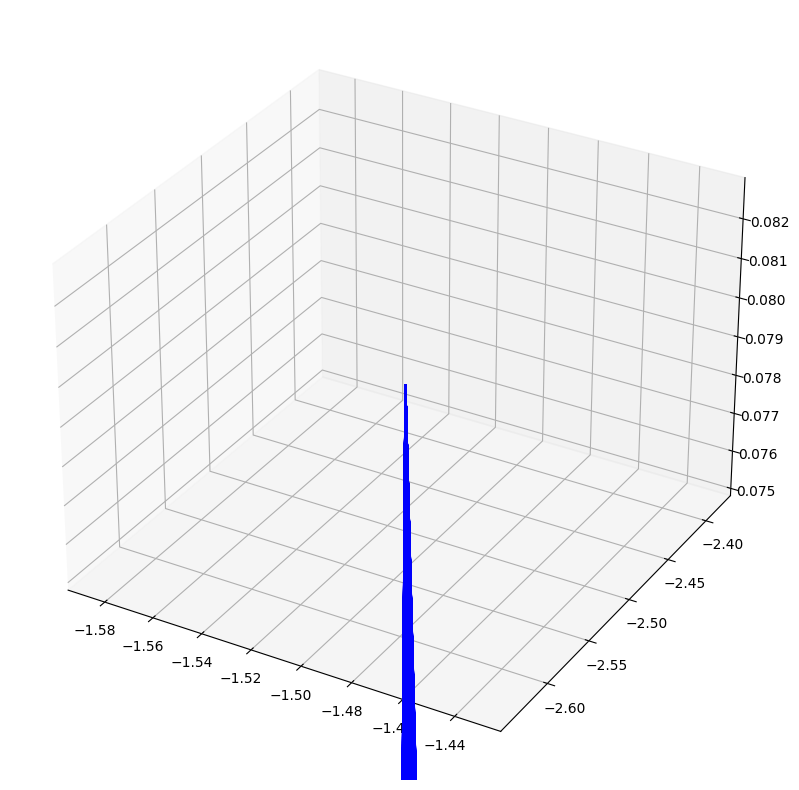

In [35]:
# Extract the data for the selected view
origins = scene_rays_o[view_idx].reshape(-1, 3).numpy()
directions = scene_rays_d[view_idx].reshape(-1, 3).numpy()

# Create a 3D plot to visualize the rays
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot rays
for origin, direction in zip(origins, directions):
    ax.quiver(
        origin[0], origin[1], origin[2],
        direction[0], direction[1], direction[2],
        length=0.1, normalize=True, color='b', alpha=0.5
    )

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Visualization of Scene Rays')

# Show plot
plt.show()

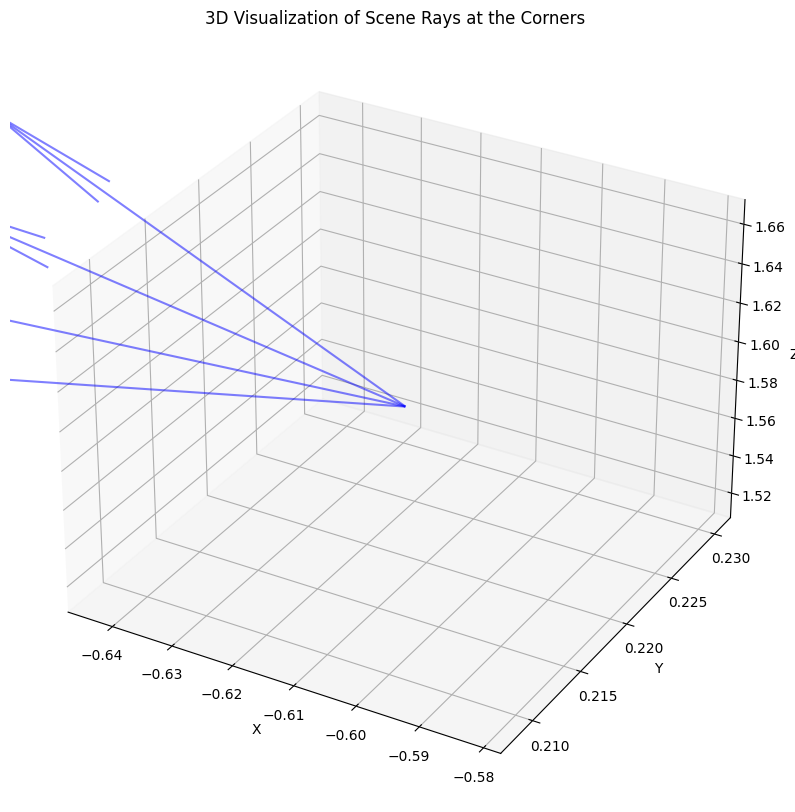

In [21]:
# Select the four corners
corner_indices = [(0, 0), (0, W-1), (H-1, 0), (H-1, W-1)]
origins = [scene_rays_o[view_idx, h, w].numpy() for h, w in corner_indices]
directions = [scene_rays_d[view_idx, h, w].numpy() for h, w in corner_indices]

# Create a 3D plot to visualize the rays at the corners
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot rays
for origin, direction in zip(origins, directions):
    ax.quiver(
        origin[0], origin[1], origin[2],
        direction[0], direction[1], direction[2],
        length=0.1, normalize=True, color='b', alpha=0.5
    )

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Visualization of Scene Rays at the Corners')

# Show plot
plt.show()

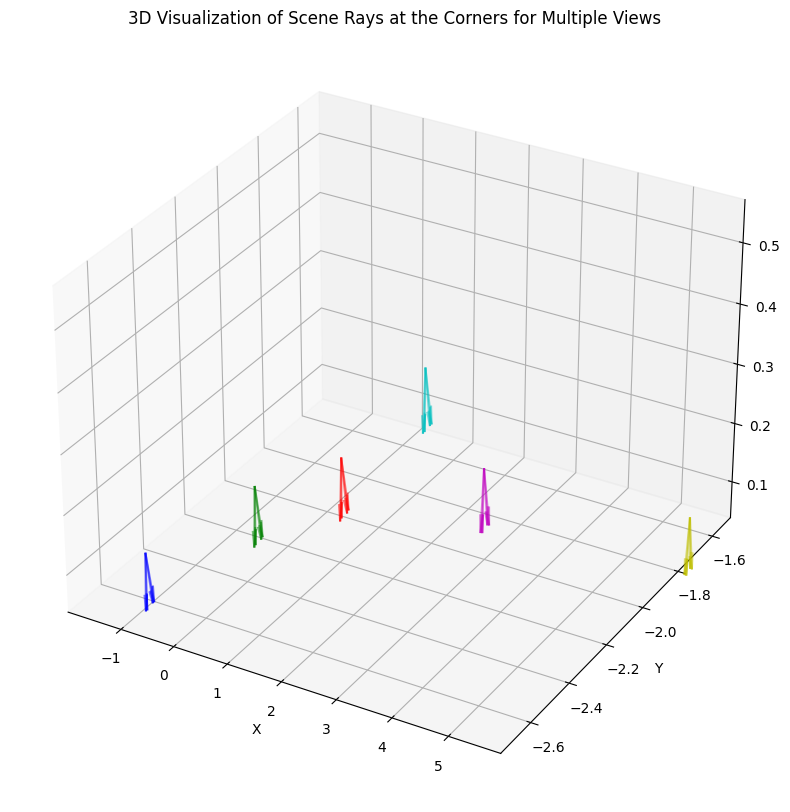

In [49]:
view_indices = [0, 1, 2, 3, 4, 5]  # List of view indices to visualize

# Compute scene_rays_d and scene_rays_o for all views
scene_rays_d = torch.zeros((C2W.shape[0], W, H, 3))
scene_rays_o = torch.zeros((C2W.shape[0], W, H, 3))

u, v = torch.meshgrid(torch.arange(W), torch.arange(H), indexing='ij')
dirs = torch.stack((v - W / 2, -(u - H / 2.), - torch.ones_like(u) * focal_length), axis=-1)

for view_idx in range(C2W.shape[0]):
    dirs_transformed = (C2W[view_idx, :3, :3] @ dirs[..., None]).squeeze(-1)
    scene_rays_d[view_idx] = dirs_transformed / torch.norm(dirs_transformed, dim=-1, keepdim=True)
    scene_rays_o[view_idx] = torch.zeros_like(scene_rays_d[view_idx]) + C2W[view_idx, :3, 3]

# Select the four corners
corner_indices = [(0, 0), (0, W-1), (H-1, 0), (H-1, W-1)]

# Create a 3D plot to visualize the rays at the corners for multiple views
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Different colors for different views

for i, view_idx in enumerate(view_indices):
    origins = [scene_rays_o[view_idx, w, h].numpy() for w, h in corner_indices]
    directions = [scene_rays_d[view_idx, w, h].numpy() for w, h in corner_indices]

    # Plot rays for the current view
    for origin, direction in zip(origins, directions):
        ax.quiver(
            origin[0], origin[1], origin[2],
            direction[0], direction[1], direction[2],
            length=0.1, normalize=True, color=colors[i % len(colors)], alpha=0.5
        )

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Visualization of Scene Rays at the Corners for Multiple Views')

# Show plot
plt.show()

In [ ]:
# for images, labels in data_loader:
#     print(f'Batch size: {images.size()}')
#     print(f'Labels: {labels}')

for batch, _ in data_loader:
  print(batch.shape)

torch.Size([29, 3, 378, 504])


In [1]:
import pickle

In [2]:
with open("/content/drive/MyDrive/training_data_800x800.pkl", 'rb') as file:
  data = pickle.load(file)

In [11]:
print(data.shape)
# print(data[109000:110000, :3])
print(data[909000:910000, :3])

(64000000, 9)
[[-1.3986591  3.5542498  1.2888215]
 [-1.3986591  3.5542498  1.2888215]
 [-1.3986591  3.5542498  1.2888215]
 ...
 [-1.3986591  3.5542498  1.2888215]
 [-1.3986591  3.5542498  1.2888215]
 [-1.3986591  3.5542498  1.2888215]]


# HiFA

In [1]:
!git clone https://github.com/JunzheJosephZhu/HiFA.git

Cloning into 'HiFA'...
remote: Enumerating objects: 339, done.
remote: Counting objects: 100% (339/339), done.
remote: Compressing objects: 100% (252/252), done.
remote: Total 339 (delta 87), reused 278 (delta 47), pack-reused 0
Receiving objects: 100% (339/339), 21.57 MiB | 17.09 MiB/s, done.
Resolving deltas: 100% (87/87), done.


In [5]:
!pip install -r ./HiFA/requirements.txt

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117
  Cloning https://github.com/NVlabs/nvdiffrast to /tmp/pip-req-build-dd10s19z
  Running command git clone --filter=blob:none --quiet https://github.com/NVlabs/nvdiffrast /tmp/pip-req-build-dd10s19z
  Resolved https://github.com/NVlabs/nvdiffrast to commit c5caf7bdb8a2448acc491a9faa47753972edd380
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 799.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 694.7/694.7 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.3/274.3 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 35.2 MB/s eta 0:00:00
    

In [6]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu117.html

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu117.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 19.0 MB/s eta 0:00:00


In [18]:
!pip install "jax[cuda12_pip]==0.4.23" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.8/131.8 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.3/363.3 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.5/22.5 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 895.7/895.7 kB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.3/130.3 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.6/217.6 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [20]:
! python ./HiFA/main1.py --text "a baby bunny sitting on top of a stack of pancakes" --workspace trials_throne_sanity --dir_text --albedo --phi_range 0 120

2024-07-02 14:54:17.364916: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-02 14:54:17.364971: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-02 14:54:17.366202: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-02 14:54:18.557187: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid